In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Various audio processing functionalities
import librosa
#Just to find the ceil 
import math
#Visualization of model history
import matplotlib.pyplot as plt
#Memory maps and various computations involving arrays
import numpy as np
#File read/information retrieval
import os
#CSV file manipulation
import pandas as pd
#To shuffle and split the dataset. We use it here to split indices of memory maps.
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import time

### Assumptions
- Values produced by mfcc are of data type float64 
- Number of classes less than 255 since we use uint8 to create memory maps.
- In create_dataset function, we use 8 as a constant to calculate train/validation/test sizes since float64 uses 8 bytes

### To do
- [ ] use os.poth.join 

In [3]:
def Augment_Song(signal,sample_rate,n_augmentations):
    signals=list()
    signals.append(signal)
    #print("Original")
    if(n_augmentations<=0):
        return signals 
    transform1 = AddGaussianNoise(min_amplitude=0.001,max_amplitude=0.015,p=1.0)
    augmented_sound = transform1(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Gaussian Noise")
    if(n_augmentations<=1):
        return signals 
    transform2 =  TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    augmented_sound = transform2(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Time Stretch")
    if(n_augmentations<=2):
        return signals 
    transform3=PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
    augmented_sound=transform3(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Pitch Shift")
    if(n_augmentations<=3):
        return signals 
    transform4=Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
    augmented_sound=transform4(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Shift")
    if(n_augmentations<=4):
        return signals 
    transform5= Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-1, max_semitones=1, p=0.5),
    Shift(min_fraction=-0.2, max_fraction=0.2, p=0.5),
    ])
    augmented_sound=transform5(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Combined Transforms") 
    return signals

In [4]:
def Preprocess(MEMORY_MAPPING_PATH,ERROR_PATH,DATASET_PATH,CSV_PATH,SAMPLE_RATE,TRACK_DURATION,num_mfcc,n_fft,hop_length,n_segments,n_augmentations):
    Function_start_time=time.time()
    if(CSV_PATH==None):
        print("Creating csv file for songs")
        df=pd.DataFrame(list(),columns=["Filename","Genre","Path"])
        for genre_folder in next(os.walk(DATASET_PATH))[1]:
            for file in next(os.walk(DATASET_PATH+genre_folder+"/"))[2]:
                df.loc[len(df.index)]=[file,genre_folder.title(),DATASET_PATH+genre_folder+"/"+file+"/"]
    elif(CSV_PATH==None and DATASET_PATH==None):
        raise ValueError('Either dataset or csv file must be given')
    else:
        df=pd.read_csv(CSV_PATH)

    #To shuffle. Not needed since we are using train test split for shuffling which is a better way since this will only shuffle songs not segments as well.
    #df=df.sample(n = len(df.index))
    
    #delete memory mapping if present in directory
    file_list=["X","y","MM_X_train","MM_X_validation","MM_X_test","MM_y_train","MM_y_validation","MM_y_test"]
    for file in file_list:
        try:
            os.remove(MEMORY_MAPPING_PATH+file+".mymemmap")
        except FileNotFoundError:
            continue
    try:

        genre_list=sorted(list(df["Genre"].unique()))
        print(f"Classes present in the csv file : {genre_list}")
        error_df=pd.DataFrame(list(),columns=['Filename','Genre','Path','Segment','Error'])

        max_input_size=len(df.index)*(n_augmentations+1)*n_segments
        X = np.memmap(MEMORY_MAPPING_PATH+"X.mymemmap", dtype='float64', mode='w+', shape=(max_input_size, num_mfcc*n_segments, num_mfcc))
        y = np.memmap(MEMORY_MAPPING_PATH+"y.mymemmap", dtype='uint8', mode='w+', shape=(max_input_size,))
        print("Empty memory map file created.")

        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
        samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        song_count=1
        count=0

        for index,row in df.iterrows():
            starting_time=time.time()
            print(f"{song_count}. {row['Filename']} : {genre_list.index(row['Genre'])}")
            try:
                signal, sample_rate = librosa.load(row['Path'], sr=SAMPLE_RATE)
            except Exception as e:
                error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],"",e]
                print("ERROR : Couldn't read file")
                continue

            signals=Augment_Song(signal,sample_rate,n_augmentations)
            for signal in signals:
                for d in range(n_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if(len(mfcc) == num_mfcc_vectors_per_segment):
                        X[count,:]=mfcc
                        y[count]=genre_list.index(row['Genre'])
                        count+=1
                    else:
                        print(f"ERROR : Segment {d} skipped.")
                        error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],d,"Length of mfcc not consistent with our calculation"]
            song_count+=1
            ending_time=time.time()
            print(ending_time-starting_time,"seconds",end="\n")

        print("Data added to memory map X and y")
        actual_size=len(X)
        d=np.zeros((num_mfcc*n_segments, num_mfcc),dtype=float)
        for i in range(-1,-len(X),-1):
            if(np.array_equal(X[-i],d)):
                actual_size-=1
        index_list=np.arange(0, actual_size, 1, dtype=int)
        train_indices,test_indices=train_test_split(index_list,test_size=0.25,shuffle=True,random_state=11)
        train_indices,validation_indices=train_test_split(train_indices,test_size=0.2,shuffle=True,random_state=11)
        print(f"Actual dataset size : {actual_size} Train set size : {len(train_indices)} Validation set size : {len(validation_indices)} Test set size : {len(test_indices)}")

        MM_X_train = np.memmap(MEMORY_MAPPING_PATH+"X_train.mymemmap", dtype='float64', mode='w+', shape=(len(train_indices), num_mfcc*n_segments, num_mfcc))
        MM_X_validation = np.memmap(MEMORY_MAPPING_PATH+"X_validation.mymemmap", dtype='float64', mode='w+', shape=(len(validation_indices), num_mfcc*n_segments, num_mfcc))
        MM_X_test = np.memmap(MEMORY_MAPPING_PATH+"X_test.mymemmap", dtype='float64', mode='w+', shape=(len(test_indices), num_mfcc*n_segments, num_mfcc))
        MM_y_train = np.memmap(MEMORY_MAPPING_PATH+"y_train.mymemmap", dtype='uint8', mode='w+', shape=(len(train_indices),))
        MM_y_validation = np.memmap(MEMORY_MAPPING_PATH+"y_validation.mymemmap", dtype='uint8', mode='w+', shape=(len(validation_indices),))
        MM_y_test = np.memmap(MEMORY_MAPPING_PATH+"y_test.mymemmap", dtype='uint8', mode='w+', shape=(len(test_indices),))
        print("Empty memory maps created")

        for index in range(0,actual_size):
            print(index,end=":")
            if(index in train_indices):
                print("train")
                MM_X_train[np.where(train_indices == index)[0][0],:]=X[index]
                MM_y_train[np.where(train_indices == index)[0][0]]=y[index]
            elif(index in validation_indices):
                print("validation")
                MM_X_validation[np.where(validation_indices == index)[0][0],:]=X[index]
                MM_y_validation[np.where(validation_indices == index)[0][0]]=y[index]
            elif(index in test_indices):
                print("test")
                MM_X_test[np.where(test_indices == index)[0][0],:]=X[index]
                MM_y_test[np.where(test_indices == index)[0][0]]=y[index]
            else:
                print(f"ERROR : Index {count} not in train,validation or test indices")

        del X
        del y
        del MM_X_train 
        del MM_X_validation
        del MM_X_test
        del MM_y_train
        del MM_y_validation
        del MM_y_test  
        for file in ["X","y"]:
            try:
                os.remove(MEMORY_MAPPING_PATH+file+".mymemmap")
            except FileNotFoundError:
                continue
        error_df.to_csv(ERROR_PATH,index=False)

    except Exception as e:
        print("Exception occured : ",e)
        for variable in file_list:
            myVars = locals()
            try:
                del myVars[variable]
            except NameError:
                continue

    Function_end_time=time.time()
    print(f"\n\n\nPreprocessing Execution Time : {Function_end_time-Function_start_time}")

In [5]:
def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='tanh'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='tanh'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [6]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [7]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    #1, 130, 13, 1 -> 10 segments with 13 mfcc? -> 13 features in each 10 segments so total : 130??

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [8]:
def create_global_test():
    pass

In [9]:
def create_dataset(MEMORY_MAPPING_PATH):
    
    s=time.time()
    #Here 8 is because float64 uses 8 bytes. [float64 uses 64 bits -> 8 bytes]
    file_size = os.path.getsize(MEMORY_MAPPING_PATH+"X_train.mymemmap")
    train_size=int(file_size/(num_mfcc*n_segments*num_mfcc*8))
    file_size = os.path.getsize(MEMORY_MAPPING_PATH+"X_validation.mymemmap")
    validation_size=int(file_size/(num_mfcc*n_segments*num_mfcc*8))
    file_size = os.path.getsize(MEMORY_MAPPING_PATH+"X_test.mymemmap")
    test_size=int(file_size/(num_mfcc*n_segments*num_mfcc*8))
    print(f"Train, Validation, Test Memory maps of sizes {train_size}, {validation_size}, {test_size} read respectively")
    
    X_train = np.memmap(MEMORY_MAPPING_PATH+"X_train.mymemmap", dtype='float64', mode='r', shape=(train_size, num_mfcc*n_segments, num_mfcc))
    X_validation = np.memmap(MEMORY_MAPPING_PATH+"X_validation.mymemmap", dtype='float64', mode='r', shape=(validation_size,num_mfcc*n_segments, num_mfcc))
    X_test = np.memmap(MEMORY_MAPPING_PATH+"X_test.mymemmap", dtype='float64', mode='r', shape=(test_size, num_mfcc*n_segments, num_mfcc))
    y_train = np.memmap(MEMORY_MAPPING_PATH+"y_train.mymemmap", dtype='uint8', mode='r', shape=(train_size,))
    y_validation = np.memmap(MEMORY_MAPPING_PATH+"y_validation.mymemmap", dtype='uint8', mode='r', shape=(validation_size,))
    y_test = np.memmap(MEMORY_MAPPING_PATH+"y_test.mymemmap", dtype='uint8', mode='r', shape=(test_size,))


    input_example_shape =  X_train[0].shape
    input_dtype = np.float64
    print(f"Input example shape : {input_example_shape} Input datatype : {input_dtype}")

    # generator function
    def X_train_generator():
        return iter(X_train)
    def X_validation_generator():
        return iter(X_validation)
    def X_test_generator():
        return iter(X_test)

    # create tf dataset from generator fn
    X_train_dataset = tf.data.Dataset.from_generator(
        generator=X_train_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_validation_dataset = tf.data.Dataset.from_generator(
        generator=X_validation_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_test_dataset = tf.data.Dataset.from_generator(
        generator=X_test_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )

    label_example_shape=y_train[0].shape
    label_data_dtype=np.uint8
    print(f"Label example shape : {label_example_shape} Label datatype : {label_data_dtype}")

    # generator function
    def y_train_generator():
        return iter(y_train)
    def y_validation_generator():
        return iter(y_validation)
    def y_test_generator():
        return iter(y_test)

    # create tf dataset from generator fn
    y_train_dataset = tf.data.Dataset.from_generator(
        generator=y_train_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_validation_dataset = tf.data.Dataset.from_generator(
        generator=y_validation_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_test_dataset = tf.data.Dataset.from_generator(
        generator=y_test_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )

    train_dataset= tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
    validation_dataset= tf.data.Dataset.zip((X_validation_dataset, y_validation_dataset))
    test_dataset= tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

    def RESHAPE(tensor_value,label):
        tensor_value=tf.reshape(tensor_value,(input_example_shape[0], input_example_shape[1],1))
        tensor_value.set_shape(tensor_value.shape)
        return (tensor_value,label)

    train_dataset = train_dataset.map(RESHAPE)
    validation_dataset = validation_dataset.map(RESHAPE)
    test_dataset = test_dataset.map(RESHAPE)

    train_batch=train_dataset.batch(32)
    validation_batch=validation_dataset.batch(32)
    test_batch=test_dataset.batch(32)

    print(f"Dataset created : {time.time()-s} Seconds")
    return train_batch,validation_batch,test_batch

In [10]:
def training(MEMORY_MAPPING_PATH="",ERROR_PATH="",MODEL_SAVE_DIRECTORY="",DATASET_PATH=None,CSV_PATH=None,remove=False,SAMPLE_RATE=22050,TRACK_DURATION = 30,num_mfcc=13,n_fft=2048,hop_length=512,n_segments=10,n_augmentations=0):
    """
    If no csv file, assuming mp3/wav files are in respective genre folder where folder name = genre label
    If there is a csv file with dataset, columns = [Filename,Genre,Path]
    """
    s=time.time()
    #numpy memory mapping gets created, error_csv gets created
    if(remove==True):
        print("If memory mapping exists, will be deleted else will be created.")
        Preprocess(MEMORY_MAPPING_PATH,ERROR_PATH,DATASET_PATH,CSV_PATH,SAMPLE_RATE,TRACK_DURATION,num_mfcc,n_fft,hop_length,n_segments,n_augmentations)
    
    #df=pd.read_csv(CSV_PATH)
    #error_df=pd.read_csv(ERROR_PATH)
    #df=pd.merge(df,error_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

    train_batch,validation_batch,test_batch=create_dataset(MEMORY_MAPPING_PATH)

    input_shape=(num_mfcc*n_segments, num_mfcc,1)
    model=build_model(input_shape)
    print("Model built")

    optimiser = keras.optimizers.Adam(learning_rate=0.00000001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model compiled")
    model.summary()

    history = model.fit(train_batch,epochs=30,validation_data=validation_batch,verbose=1)
    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(test_batch, verbose=2)
    print('\nTest accuracy:', test_acc)

    try:
        model.save(MODEL_SAVE_DIRECTORY)
        print("Model saved")
        print(f"Training Execution Time : {time.time()-s} Seconds")
        return f"MODEL SUCESSFULLY SAVED AT {MODEL_SAVE_PATH}"
    except:
        print(f"Training Execution Time : {time.time()-s} Seconds")
        return model

Train, Validation, Test Memory maps of sizes 5991, 1498, 2497 read respectively
Input example shape : (130, 13) Input datatype : <class 'numpy.float64'>
Label example shape : () Label datatype : <class 'numpy.uint8'>
Dataset created : 0.1348860263824463 Seconds
Model built
Model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 

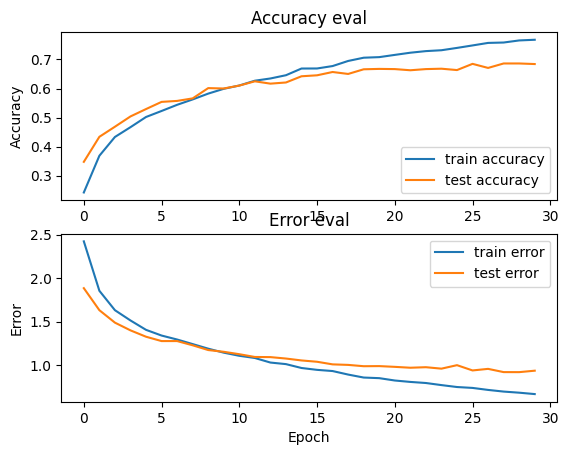

79/79 - 2s - loss: 0.8908 - accuracy: 0.6976

Test accuracy: 0.697637140750885
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D://Downloads/MGR Data/Models/EXPERIMENT/assets
Model saved


In [31]:
training(MEMORY_MAPPING_PATH,ERROR_PATH,MODEL_SAVE_DIRECTORY,DATASET_PATH,CSV_PATH,remove=False)

In [11]:
CSV_PATH="D:/Downloads/MGR Data/Metadata/Datasets/Combined/Balanced_515_Tracks_12_classes.csv"
MEMORY_MAPPING_PATH = "D:/Downloads/MGR Data/Metadata/Datasets/Combined/"
ERROR_PATH="D:/Downloads/MGR Data/Metadata/Datasets/Combined/Error.csv"
MODEL_SAVE_DIRECTORY="D:/Downloads/MGR Data/Models/EXPERIMENT 2/"
DATASET_PATH=None
SAMPLE_RATE=22050
TRACK_DURATION = 30
num_mfcc=13
n_fft=2048
hop_length=512
n_segments=10
n_augmentations=0

In [ ]:
training(MEMORY_MAPPING_PATH,ERROR_PATH,MODEL_SAVE_DIRECTORY,DATASET_PATH,CSV_PATH,remove=True)